## Download and read data

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandahouse
%matplotlib inline

In [41]:
def select(query):
    return pandahouse.read_clickhouse(query, connection=connection)

In [42]:
connection = {
    'database': 'simulator_20221120',
    'host': 'https://clickhouse.lab.karpov.courses',
    'user': 'student',
    'password': 'dpo_python_2020'
}

In [43]:
query = '''
select exp_group, user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes / views as ctr
from {db}.feed_actions 
where toDate(time) between '2022-10-26' and '2022-11-01' and exp_group in (2, 3)
group by exp_group, user_id
'''

In [44]:
df = select(query)

In [45]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


## Histogram

In [46]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


Размеры групп примерно одинаковые.

<AxesSubplot:xlabel='ctr', ylabel='Count'>

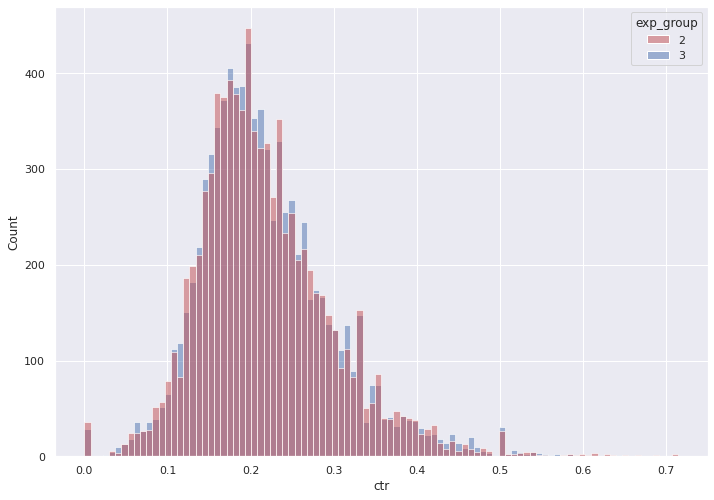

In [47]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.histplot(data=df, x='ctr', hue='exp_group', kde=False, palette=['r', 'b'], alpha=0.5)

Метрики CTR в группах примерно одинаковые.

## Bootstrapping

In [48]:
group_A = df[df['exp_group'] == 2].copy()

In [49]:
group_B = df[df['exp_group'] == 3].copy()

In [50]:
pvalues = []
for i in range(10000):
    statistic, pvalue = stats.ttest_ind(group_A['ctr'].sample(500, replace=False), group_B['ctr'].sample(500, replace=False), equal_var=False)
    pvalues.append(pvalue)

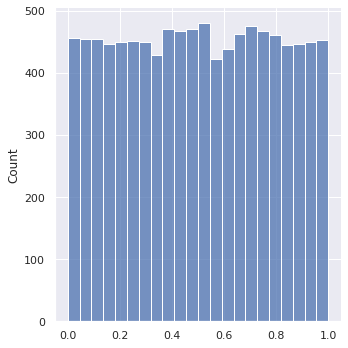

In [51]:
sns.displot(pvalues)

Распределение p-values похоже на равномерное. 

In [52]:
sum(np.array(pvalues) <= 0.05) / 10000

0.05

## Summary

Система сплитования в целом работает корректно. Ключевая метрика между группами не отличается в тесте и, основываясь на данных bootstrapping, в целом.
Группы не отличаются между собой и можно утверждать, что возникшее после воздействия отличие будет вызвано воздействием.  